In [1]:
import pandas as pd
import numpy as np

In [2]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "QLIKE" and crit != "MAD" and crit != "MAPE"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        #for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
        #    is_actual_ok = compiled_regex(str(abs(actual)))
        #    is_pred1_ok = compiled_regex(str(abs(pred1)))
        #    is_pred2_ok = compiled_regex(str(abs(pred2)))
        #    if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
        #        msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
        #        rt = -1
        #        return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "QLIKE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((abs(actual)/abs(p1)-np.log(abs(actual)/abs(p1))-1))
            e2_lst.append((abs(actual)/abs(p2)-np.log(abs(actual)/abs(p2))-1))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return DM_stat

In [3]:
GARCH=pd.read_excel("GARCH(1,1)-Norm forecasts.xlsx")#,index_col= "Date")
HAR=pd.read_excel("HAR Forecasts.xlsx")#, index_col= "Date")

In [4]:
NBEATSx=pd.read_excel("NBEATSx forecasts.xlsx")#, index_col= "Date")

In [5]:
NHITS=pd.read_excel("NHITS forecasts.xlsx")#, index_col= "Date")

In [6]:
LSTM=pd.read_excel("LSTM forecasts.xlsx")#, index_col= "Date")

In [7]:
TFT=pd.read_excel("TFT forecasts.xlsx")#, index_col= "Date")

In [8]:
Actuals=pd.read_excel("Actuals.xlsx")

In [9]:
mask=GARCH['Date'].isin(NBEATSx['Date'])
GARCH=GARCH.loc[mask]

In [10]:
mask=HAR['Date'].isin(GARCH['Date'])
HAR=HAR.loc[mask]

In [11]:
mask=NBEATSx['Date'].isin(GARCH['Date'])
NBEATSx=NBEATSx.loc[mask]

In [12]:
mask=NHITS['Date'].isin(GARCH['Date'])
NHITS=NHITS.loc[mask]

In [13]:
mask=LSTM['Date'].isin(GARCH['Date'])
LSTM=LSTM.loc[mask]

In [14]:
mask=TFT['Date'].isin(GARCH['Date'])
TFT=TFT.loc[mask]

In [15]:
mask=Actuals['Date'].isin(GARCH['Date'])
Actuals=Actuals.loc[mask]

In [16]:
GARCH.set_index('Date',inplace=True)
HAR.set_index('Date',inplace=True)
NBEATSx.set_index('Date',inplace=True)
NHITS.set_index('Date',inplace=True)
LSTM.set_index('Date',inplace=True)
TFT.set_index('Date',inplace=True)
Actuals.set_index('Date',inplace=True)

# Error Metrics

RMSE

In [19]:
NHITS_RMSE=(NHITS-Actuals)**2
NBEATSx_RMSE=(NBEATSx-Actuals)**2
TFT_RMSE=(TFT-Actuals)**2
LSTM_RMSE=(LSTM-Actuals)**2
HAR_RMSE=(HAR-Actuals)**2
GARCH_RMSE=(GARCH-Actuals)**2

NHITS_RMSE=np.sqrt(NHITS_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_RMSE=np.sqrt(NBEATSx_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_RMSE=np.sqrt(TFT_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
LSTM_RMSE=np.sqrt(LSTM_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_RMSE=np.sqrt(HAR_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_RMSE=np.sqrt(GARCH_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS RMSE: {NHITS_RMSE}")
print(f"NBEATSx RMSE: {NBEATSx_RMSE}")
print(f"TFT RMSE: {TFT_RMSE}")
print(f"LSTM RMSE: {LSTM_RMSE}")
print(f"HAR RMSE: {HAR_RMSE}")
print(f"GARCH RMSE: {GARCH_RMSE}")

NHITS RMSE: 0.004666164677731019
NBEATSx RMSE: 0.00446173579861226
TFT RMSE: 0.004520484795155957
LSTM RMSE: 0.005620840616457368
HAR RMSE: 0.004041547699822895
GARCH RMSE: 0.0055943337601712766


MAE

In [20]:
NHITS_MAE=abs(NHITS-Actuals)
NBEATSx_MAE=abs(NBEATSx-Actuals)
TFT_MAE=abs(TFT-Actuals)
LSTM_MAE=abs(LSTM-Actuals)
HAR_MAE=abs(HAR-Actuals)
GARCH_MAE=abs(GARCH-Actuals)

NHITS_MAE=(NHITS_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_MAE=(NBEATSx_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_MAE=(TFT_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
LSTM_MAE=(LSTM_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_MAE=(HAR_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_MAE=(GARCH_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS MAE: {NHITS_MAE}")
print(f"NBEATSx MAE: {NBEATSx_MAE}")
print(f"TFT MAE: {TFT_MAE}")
print(f"LSTM MAE: {LSTM_MAE}")
print(f"HAR MAE: {HAR_MAE}")
print(f"GARCH MAE: {GARCH_MAE}")

NHITS MAE: 0.002956507115282785
NBEATSx MAE: 0.0028630376253563454
TFT MAE: 0.002981403473832719
LSTM MAE: 0.003263220366972306
HAR MAE: 0.0026806755879016718
GARCH MAE: 0.0036273176771332437


QLIKE

In [21]:
NHITS_QLIKE=(Actuals/NHITS)-np.log(Actuals/NHITS)-1
NBEATSx_QLIKE=(Actuals/NBEATSx)-np.log(Actuals/NBEATSx)-1
TFT_QLIKE=(Actuals/TFT)-np.log(Actuals/TFT)-1
LSTM_QLIKE=(Actuals/LSTM)-np.log(Actuals/LSTM)-1
HAR_QLIKE=(Actuals/HAR)-np.log(Actuals/HAR)-1
GARCH_QLIKE=(Actuals/GARCH)-np.log(Actuals/GARCH)-1

NHITS_QLIKE=(NHITS_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_QLIKE=(NBEATSx_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_QLIKE=(TFT_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
LSTM_QLIKE=(LSTM_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_QLIKE=(HAR_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_QLIKE=(GARCH_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS QLIKE: {NHITS_QLIKE}")
print(f"NBEATSx QLIKE: {NBEATSx_QLIKE}")
print(f"TFT QLIKE: {TFT_QLIKE}")
print(f"LSTM QLIKE: {LSTM_QLIKE}")
print(f"HAR QLIKE: {HAR_QLIKE}")
print(f"GARCH QLIKE: {GARCH_QLIKE}")

NHITS QLIKE: 0.03797179567934479
NBEATSx QLIKE: 0.03669203895716411
TFT QLIKE: 0.036252871024841135
LSTM QLIKE: 0.050386445517687305
HAR QLIKE: 0.031115567539635996
GARCH QLIKE: 0.04846241411470962


MAPE

In [22]:
NHITS_MAPE=abs(Actuals-NHITS)/Actuals
NBEATSx_MAPE=abs(Actuals-NBEATSx)/Actuals
TFT_MAPE=abs(Actuals-TFT)/Actuals
LSTM_MAPE=abs(Actuals-LSTM)/Actuals
HAR_MAPE=abs(Actuals-HAR)/Actuals
GARCH_MAPE=abs(Actuals-GARCH)/Actuals

NHITS_MAPE=(NHITS_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_MAPE=(NBEATSx_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_MAPE=(TFT_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
LSTM_MAPE=(LSTM_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_MAPE=(HAR_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_MAPE=(GARCH_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS MAPE: {NHITS_MAPE}")
print(f"NBEATSx MAPE: {NBEATSx_MAPE}")
print(f"TFT MAPE: {TFT_MAPE}")
print(f"LSTM MAPE: {LSTM_MAPE}")
print(f"HAR MAPE: {HAR_MAPE}")
print(f"GARCH MAPE: {GARCH_MAPE}")

NHITS MAPE: 0.20551709631972276
NBEATSx MAPE: 0.19923817737766839
TFT MAPE: 0.21408339704741192
LSTM MAPE: 0.21118413966184005
HAR MAPE: 0.19500019401985466
GARCH MAPE: 0.27154904159808024


In [23]:
# Creating a dataframe with the error metrics as columns and models as the index
error_metrics_data = {
    'RMSE': [NHITS_RMSE, GARCH_RMSE, HAR_RMSE, LSTM_RMSE, TFT_RMSE, NBEATSx_RMSE],
    'MAE': [NHITS_MAE, GARCH_MAE, HAR_MAE, LSTM_MAE, TFT_MAE, NBEATSx_MAE],
    'MAPE': [NHITS_MAPE, GARCH_MAPE, HAR_MAPE, LSTM_MAPE, TFT_MAPE, NBEATSx_MAPE],
    'QLIKE': [NHITS_QLIKE, GARCH_QLIKE, HAR_QLIKE, LSTM_QLIKE, TFT_QLIKE, NBEATSx_QLIKE]
}

models = ['NHITS', 'GARCH', 'HAR', 'LSTM', 'TFT', 'NBEATSx']

# Create the DataFrame
error_metrics_df = pd.DataFrame(data=error_metrics_data, index=models)

error_metrics_df

,RMSE,MAE,MAPE,QLIKE
NHITS,0.004666,0.002957,0.205517,0.037972
GARCH,0.005594,0.003627,0.271549,0.048462
HAR,0.004042,0.002681,0.195000,0.031116
LSTM,0.005621,0.003263,0.211184,0.050386
TFT,0.004520,0.002981,0.214083,0.036253
NBEATSx,0.004462,0.002863,0.199238,0.036692


In [24]:
error_metrics_df.to_excel("Error Metrics.xlsx")

# DM tests with MSE

In [17]:
Stocks = []
for i in range(len(NHITS.columns)):
  Stocks.append(NHITS.columns[i])


If DM_stat is negative, first model is better, otherwise second one is better

In [18]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 0
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
[]
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 77
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'USB', 'VZ', 'WFC', 'WMT']


In [ ]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 0
Stocks where NHITS yields statistically significant better forecasts than HAR:
[]
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 73
Stocks where HAR yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AXP', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MRK', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']


In [ ]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 0
Stocks where NHITS yields statistically significant better forecasts than TFT:
[]
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 1
Stocks where TFT yields statistically significant better forecasts than NHITS:
['CVX']


In [ ]:
DM_statistics_LSTM_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_LSTM_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], LSTM[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than LSTM: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than LSTM:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_LSTM_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0])):
  Stocks_where_LSTM_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where LSTM yields statistically significant better forecasts than NHITS: {len(Stocks_where_LSTM_is_statistically_better)}")
print(f"Stocks where LSTM yields statistically significant better forecasts than NHITS:")
print(Stocks_where_LSTM_is_statistically_better)
NHITS_better_LSTM=len(Stocks_where_NHITS_is_statistically_better)
LSTM_better_NHITS=len(Stocks_where_LSTM_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than LSTM: 80
Stocks where NHITS yields statistically significant better forecasts than LSTM:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where LSTM yields statistically significant better forecasts than NHITS: 0
Stocks where LSTM yields statistically significant better forecasts than NHITS:
[]


In [ ]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 74
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GOOG', 'GS', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'MA', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


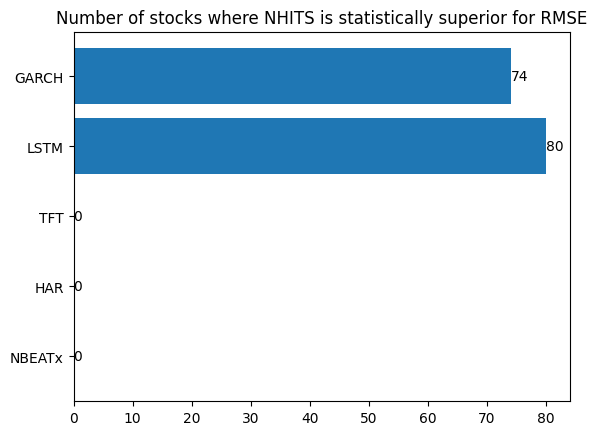

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT, NHITS_better_LSTM,NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for RMSE")
plt.show()

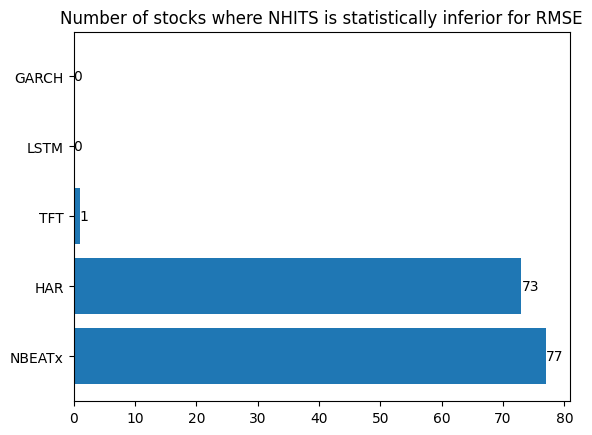

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS, LSTM_better_NHITS,GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for RMSE")
plt.show()

# DM tests with MAE

In [ ]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 0
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
[]
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 61
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CI', 'CMCSA', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'FIS', 'FISV', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SYK', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'USB', 'WFC', 'WMT']


In [ ]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 0
Stocks where NHITS yields statistically significant better forecasts than HAR:
[]
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 62
Stocks where HAR yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'BDX', 'BMY', 'CAT', 'CB', 'CMCSA', 'COP', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MRK', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UPS', 'USB', 'WMT']


In [ ]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 2
Stocks where NHITS yields statistically significant better forecasts than TFT:
['AMZN', 'NFLX']
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 0
Stocks where TFT yields statistically significant better forecasts than NHITS:
[]


In [ ]:
DM_statistics_LSTM_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_LSTM_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], LSTM[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than LSTM: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than LSTM:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_LSTM_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0])):
  Stocks_where_LSTM_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where LSTM yields statistically significant better forecasts than NHITS: {len(Stocks_where_LSTM_is_statistically_better)}")
print(f"Stocks where LSTM yields statistically significant better forecasts than NHITS:")
print(Stocks_where_LSTM_is_statistically_better)
NHITS_better_LSTM=len(Stocks_where_NHITS_is_statistically_better)
LSTM_better_NHITS=len(Stocks_where_LSTM_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than LSTM: 71
Stocks where NHITS yields statistically significant better forecasts than LSTM:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'C', 'CB', 'CI', 'CMCSA', 'COP', 'COST', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'ISRG', 'JNJ', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where LSTM yields statistically significant better forecasts than NHITS: 0
Stocks where LSTM yields statistically significant better forecasts than NHITS:
[]


In [ ]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 80
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


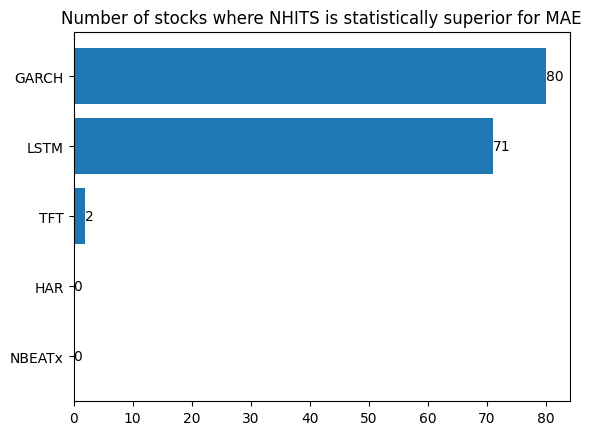

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT, NHITS_better_LSTM,NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for MAE")
plt.show()

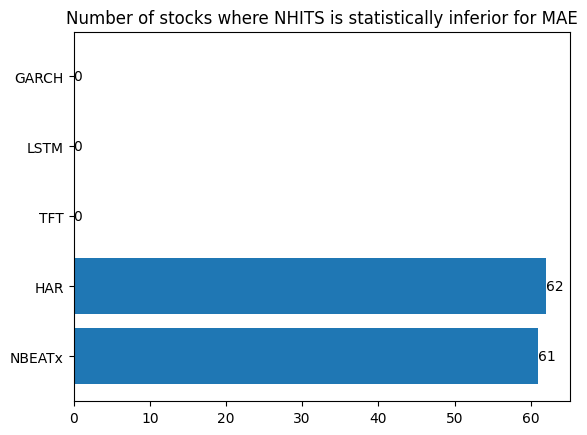

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS, LSTM_better_NHITS,GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for MAE")
plt.show()

# DM tests with QLIKE

In [ ]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 0
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
[]
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 45
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'AMT', 'AXP', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CME', 'COP', 'COST', 'CSCO', 'D', 'DUK', 'FIS', 'FISV', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'ISRG', 'MDT', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'ORCL', 'PEP', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'TGT', 'TJX', 'TXN', 'USB', 'WMT']


In [ ]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 0
Stocks where NHITS yields statistically significant better forecasts than HAR:
[]
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 70
Stocks where HAR yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AXP', 'BAC', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'USB', 'VZ', 'WFC', 'WMT']


In [ ]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 0
Stocks where NHITS yields statistically significant better forecasts than TFT:
[]
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 45
Stocks where TFT yields statistically significant better forecasts than NHITS:
['ABT', 'ACN', 'AMT', 'BAC', 'BDX', 'BSX', 'C', 'CAT', 'CB', 'COP', 'COST', 'CRM', 'CVX', 'D', 'DHR', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'JNJ', 'JPM', 'MDT', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PG', 'PNC', 'SO', 'TGT', 'TJX', 'TXN', 'UNH', 'USB', 'WFC', 'WMT']


In [ ]:
DM_statistics_LSTM_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_LSTM_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], LSTM[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than LSTM: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than LSTM:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_LSTM_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0])):
  Stocks_where_LSTM_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where LSTM yields statistically significant better forecasts than NHITS: {len(Stocks_where_LSTM_is_statistically_better)}")
print(f"Stocks where LSTM yields statistically significant better forecasts than NHITS:")
print(Stocks_where_LSTM_is_statistically_better)
NHITS_better_LSTM=len(Stocks_where_NHITS_is_statistically_better)
LSTM_better_NHITS=len(Stocks_where_LSTM_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than LSTM: 79
Stocks where NHITS yields statistically significant better forecasts than LSTM:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where LSTM yields statistically significant better forecasts than NHITS: 0
Stocks where LSTM yields statistically significant better forecasts than NHITS:
[]


In [ ]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 76
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


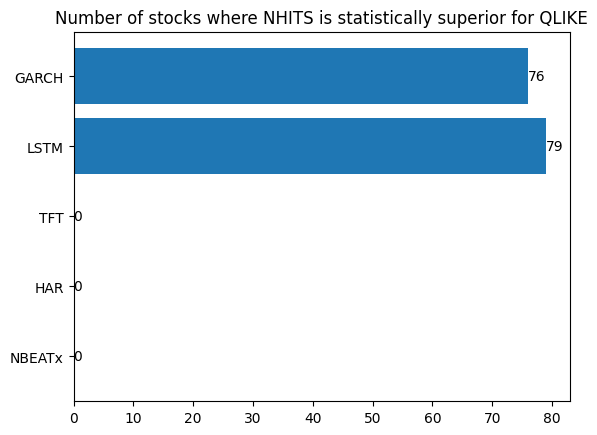

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT, NHITS_better_LSTM,NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for QLIKE")
plt.show()

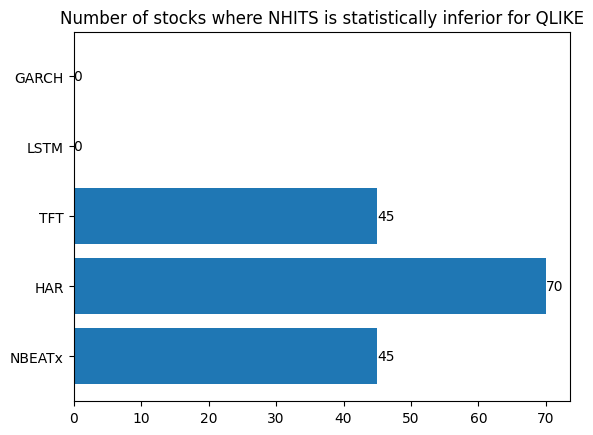

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS, LSTM_better_NHITS,GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for QLIKE")
plt.show()

# DM tests with MAPE

In [ ]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 0
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
[]
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 56
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['ACN', 'ADBE', 'ADP', 'AMGN', 'BA', 'BSX', 'C', 'CAT', 'CI', 'CMCSA', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'FIS', 'FISV', 'GE', 'GS', 'HD', 'HON', 'INTC', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PNC', 'QCOM', 'SBUX', 'SYK', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'USB', 'VZ', 'WFC', 'WMT']


In [ ]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 11
Stocks where NHITS yields statistically significant better forecasts than HAR:
['AMZN', 'AXP', 'BAC', 'BSX', 'CME', 'CRM', 'JPM', 'MS', 'NFLX', 'SBUX', 'VZ']
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 48
Stocks where HAR yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'ADBE', 'ADP', 'AMGN', 'AMT', 'BA', 'BDX', 'BMY', 'CAT', 'CB', 'COP', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GOOG', 'HON', 'IBM', 'INTC', 'INTU', 'JNJ', 'KO', 'LLY', 'LMT', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'QCOM', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UPS', 'WMT']


In [ ]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 73
Stocks where NHITS yields statistically significant better forecasts than TFT:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'KO', 'LLY', 'LMT', 'LOW', 'MCD', 'MDT', 'MMM', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TMO', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 0
Stocks where TFT yields statistically significant better forecasts than NHITS:
[]


In [ ]:
DM_statistics_LSTM_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_LSTM_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], LSTM[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than LSTM: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than LSTM:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_LSTM_is_statistically_better = []
for i in range(len(np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0])):
  Stocks_where_LSTM_is_statistically_better.append(Stocks[np.where(DM_statistics_LSTM_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where LSTM yields statistically significant better forecasts than NHITS: {len(Stocks_where_LSTM_is_statistically_better)}")
print(f"Stocks where LSTM yields statistically significant better forecasts than NHITS:")
print(Stocks_where_LSTM_is_statistically_better)
NHITS_better_LSTM=len(Stocks_where_NHITS_is_statistically_better)
LSTM_better_NHITS=len(Stocks_where_LSTM_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than LSTM: 11
Stocks where NHITS yields statistically significant better forecasts than LSTM:
['ACN', 'AMZN', 'BMY', 'IBM', 'MCD', 'MS', 'MSFT', 'NFLX', 'SO', 'T', 'VZ']
Number of stocks where LSTM yields statistically significant better forecasts than NHITS: 0
Stocks where LSTM yields statistically significant better forecasts than NHITS:
[]


In [ ]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 80
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


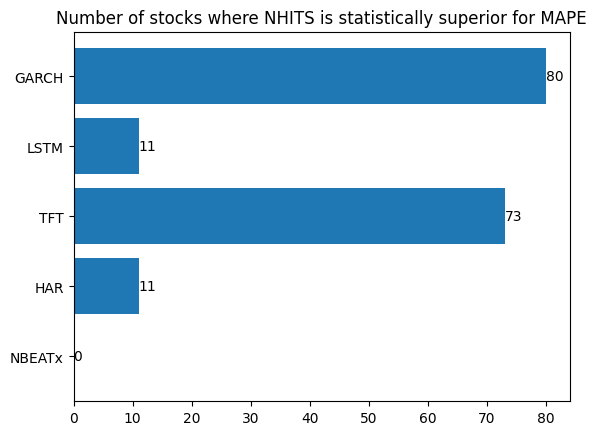

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT, NHITS_better_LSTM,NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for MAPE")
plt.show()

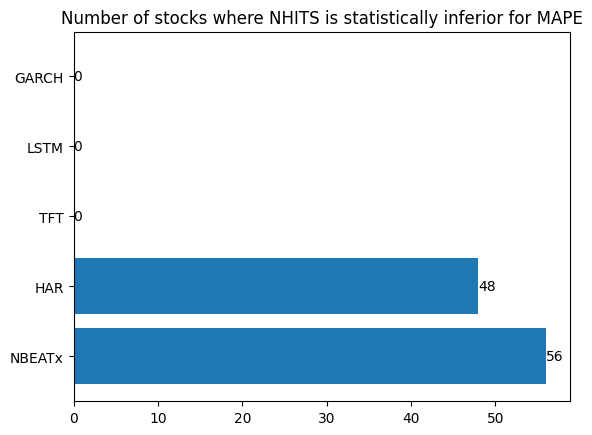

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "LSTM", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS, LSTM_better_NHITS,GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for MAPE")
plt.show()

# MCS test with MSE

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
from arch.bootstrap import MCS

Alphabetic Order: GARCH, HAR, LSTM, NBEATSx, NHITS, TFT

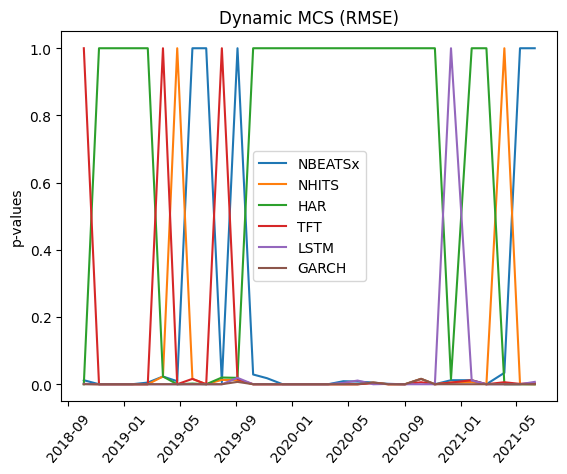

In [ ]:
NHITS_residuals=(NHITS-Actuals)**2
NBEATSx_residuals=(NBEATSx-Actuals)**2
TFT_residuals=(TFT-Actuals)**2
LSTM_residuals=(LSTM-Actuals)**2
HAR_residuals=(HAR-Actuals)**2
GARCH_residuals=(GARCH-Actuals)**2

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
LSTM_residuals=LSTM_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'LSTM': LSTM_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),6])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(6)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'LSTM':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'TFT':Dynamic_pvalues[:,5]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["LSTM"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (RMSE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'LSTM', 'GARCH'])
plt.xticks(rotation=50)
plt.show()

# MCS test with MAE

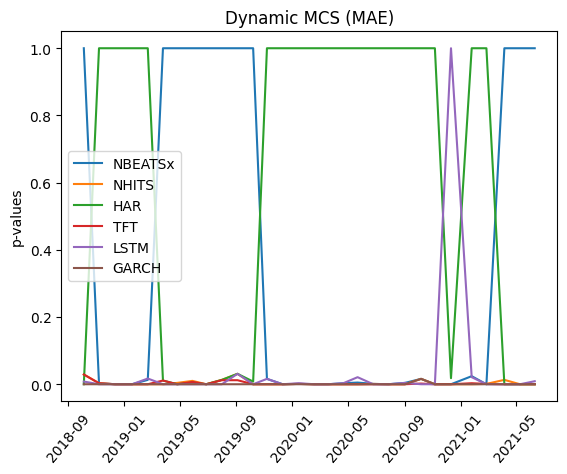

In [ ]:
NHITS_residuals=abs(NHITS-Actuals)
NBEATSx_residuals=abs(NBEATSx-Actuals)
TFT_residuals=abs(TFT-Actuals)
LSTM_residuals=abs(LSTM-Actuals)
HAR_residuals=abs(HAR-Actuals)
GARCH_residuals=abs(GARCH-Actuals)

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
LSTM_residuals=LSTM_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'LSTM': LSTM_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),6])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(6)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'LSTM':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'TFT':Dynamic_pvalues[:,5]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["LSTM"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (MAE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'LSTM', 'GARCH'])
plt.xticks(rotation=50)
plt.show()

# MCS test with QLIKE

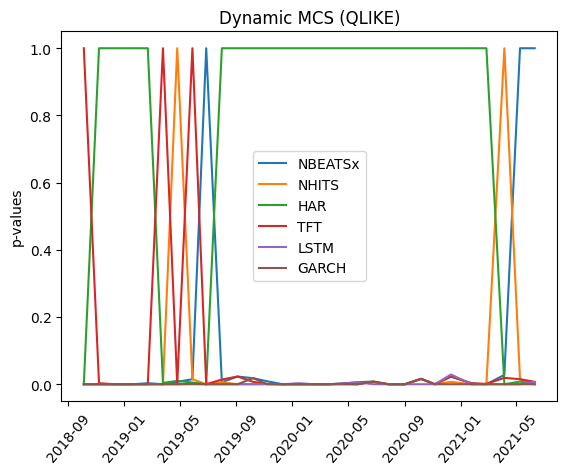

In [ ]:
NHITS_residuals=(Actuals/NHITS)-np.log(Actuals/NHITS)-1
NBEATSx_residuals=(Actuals/NBEATSx)-np.log(Actuals/NBEATSx)-1
TFT_residuals=(Actuals/TFT)-np.log(Actuals/TFT)-1
LSTM_residuals=(Actuals/LSTM)-np.log(Actuals/LSTM)-1
HAR_residuals=(Actuals/HAR)-np.log(Actuals/HAR)-1
GARCH_residuals=(Actuals/GARCH)-np.log(Actuals/GARCH)-1

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
LSTM_residuals=LSTM_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'LSTM': LSTM_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),6])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(6)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'LSTM':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'TFT':Dynamic_pvalues[:,5]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["LSTM"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (QLIKE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'LSTM', 'GARCH'])
plt.xticks(rotation=50)
plt.show()

# MCS test with MAPE

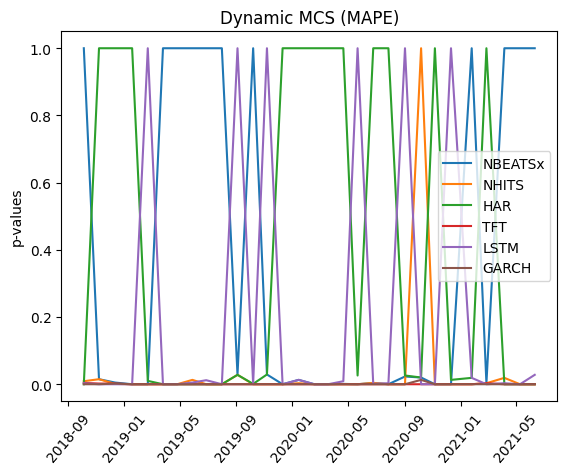

In [ ]:
NHITS_residuals=abs(Actuals-NHITS)/Actuals
NBEATSx_residuals=abs(Actuals-NBEATSx)/Actuals
TFT_residuals=abs(Actuals-TFT)/Actuals
LSTM_residuals=abs(Actuals-LSTM)/Actuals
HAR_residuals=abs(Actuals-HAR)/Actuals
GARCH_residuals=abs(Actuals-GARCH)/Actuals

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
LSTM_residuals=LSTM_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'LSTM': LSTM_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),6])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(6)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'LSTM':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'TFT':Dynamic_pvalues[:,5]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["LSTM"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (MAPE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'LSTM', 'GARCH'])
plt.xticks(rotation=50)
plt.show()